In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from itertools import count

import torch
from gym import spaces

from recsim.environments import interest_evolution
from recsim.environments import long_term_satisfaction

In [2]:
# Model and env configs
batch_size=50
lr=0.001
episilon=0.5
replay_memory_size=10000
gamma=0.9
target_update_iter=100
log_internval=10
train_episodes = 1000

env_type = 'evolve'
env_config = {'slate_size': 3,
              'seed': 0,
              'num_candidates': 5,
              'resample_documents': True}

if env_type == 'evolve':
    env = interest_evolution.create_environment(env_config)
elif env_type == 'longterm':
    env = long_term_satisfaction.create_environment(env_config)
else:
    raise ValueError('Invalid env.')

In [3]:
for key, space in env.observation_space['doc'].spaces.items():
  print(key, ':', space)

user_space = env.observation_space['user']
doc_space = env.observation_space['doc']
num_candidates = env_config['num_candidates']
doc_space_shape = spaces.flatdim(list(doc_space.spaces.values())[0])
# Use the longer of user_space and doc_space as the shape of each row.
usr_obs_shape = (np.max([spaces.flatdim(user_space), doc_space_shape]),)[0]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_action=env_config['slate_size']
action_space_of_env = env.action_space.nvec.shape[0]
n_state=usr_obs_shape + doc_space_shape * num_candidates + 5
hidden=256
print('Action space ', n_action)
print('Action space suggested by env wrapper', action_space_of_env)
print('State obs dim ', n_state)


0 : Box(20,)
1 : Box(20,)
2 : Box(20,)
3 : Box(20,)
4 : Box(20,)
Action space  3
Action space suggested by env wrapper 3
State obs dim  125


In [4]:
class net(torch.nn.Module):
    def __init__(self):
        super(net,self).__init__()
        self.fc1=torch.nn.Linear(n_state,hidden)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2=torch.nn.Linear(hidden,hidden)
        self.fc2.weight.data.normal_(0, 0.1)
        self.out=torch.nn.Linear(hidden,n_action)
        self.out.weight.data.normal_(0, 0.1)


    def forward(self,x):
        x=self.fc1(x)
        x=torch.nn.functional.relu(x)
        x=self.fc2(x)
        x=torch.nn.functional.relu(x)
        out=self.out(x)
        return out

class replay_memory():
    def __init__(self):
        self.memory_size=replay_memory_size
        self.memory=np.array([])
        self.cur=0
        self.new=0
    def size(self):
        return self.memory.shape[0]

    def store_transition(self,trans):
        # trans : [s,a,r,s',done]
        if(self.memory.shape[0]<self.memory_size):
            if self.new==0:
                self.memory=np.array(trans)
                self.new=1
            elif self.memory.shape[0]>0:
                self.memory=np.vstack((self.memory,trans))

        else:
            self.memory[self.cur,:]=trans
            self.cur=(self.cur+1)%self.memory_size

    def sample(self):
        if self.memory.shape[0]<batch_size:
            return -1
        sam=np.random.choice(self.memory.shape[0],batch_size)
        return self.memory[sam]

class DQN():

    def __init__(self):
        self.eval_q_net,self.target_q_net=net().to(device),net().to(device)
        self.replay_mem=replay_memory()
        self.iter_num=0
        self.optimizer=torch.optim.Adam(self.eval_q_net.parameters(),lr=lr)
        self.loss=torch.nn.MSELoss().to(device)

    def choose_action(self,qs):
        if np.random.uniform()<episilon:
            return torch.topk(qs,k=n_action).indices
        else:
            return torch.randint(0, n_action ,(n_action,))

    def greedy_action(self,qs):
        return torch.topk(qs,k=n_action).indices

    def learn(self):
        if(self.iter_num%target_update_iter==0):
            self.target_q_net.load_state_dict(self.eval_q_net.state_dict())
        self.iter_num+=1

        batch=self.replay_mem.sample()
        b_s=torch.FloatTensor(batch[:,0].tolist()).to(device)
        b_a=torch.LongTensor(np.array(batch[:,1].tolist())).to(device)
        b_r=torch.FloatTensor(batch[:,2].tolist()).to(device)
        b_s_=torch.FloatTensor(batch[:,3].tolist()).to(device)
        b_d=torch.FloatTensor(batch[:,4].tolist()).to(device)
        q_target=torch.zeros((batch_size,n_action)).to(device)
        q_eval=self.eval_q_net(b_s)
        q_eval=torch.gather(q_eval,dim=1,index=b_a)
        q_next=self.target_q_net(b_s_).detach()
        for i in range(b_d.shape[0]):
            if(int(b_d[i].tolist()[0])==0):
                q_target[i]=b_r[i]+gamma*torch.unsqueeze(torch.max(q_next[i],0)[0],0)
            else:
                q_target[i]=b_r[i]
        td_error=self.loss(q_eval,q_target)

        self.optimizer.zero_grad()
        td_error.backward()
        self.optimizer.step()
        return td_error.item()

def flatten_obs(obs):

    obs_usr = obs['user']
    obs_docs = obs['doc']
    response = obs['response']
    all_docs = []
    all_responses = []
    for _, item in obs_docs.items():
        all_docs.append(item)
    if response is not None:
        for _, item in response[0].items():
            all_responses.append(item)
    else:
        response_pad = np.zeros((5), dtype=np.float64)
        all_responses.append(response_pad)
    # TODO : This is ugly fix it.
    all_responses = np.array(all_responses).flatten()

    all_docs_np = np.array(all_docs).flatten()
    obs_flatten = np.concatenate((obs_usr, all_docs_np, all_responses), axis=0)
    return obs_flatten

In [5]:
dqn=DQN()
all_rewards = []
all_losses = []
all_actions = []

for episode in range(train_episodes):
    state = env.reset()
    state = flatten_obs(state)
    reward = 0.0
    done = False
    for t in count():
        t+=1
        state_tensor = torch.FloatTensor(state).to(device)
        state_normalized = torch.nn.functional.normalize(state_tensor, dim=0)
        qvals = dqn.eval_q_net(state_normalized)
        action = dqn.choose_action(qvals)
        action = action.cpu().numpy()

        next_state,reward,done,_ = env.step(action)

        next_state = flatten_obs(next_state)
        assert(not(np.array_equal(state, next_state)))
        transition=[state.tolist(),action,[reward],next_state.tolist(),[done]]
        dqn.replay_mem.store_transition(transition)

        state = next_state
        if dqn.replay_mem.size()>batch_size:
            loss = dqn.learn()
            all_losses.append(loss)
        if done:
            done = False
            break
    if episode%log_internval==0:
        # Evaluation
        total_reward=0.0
        for i in range(10):
            eval_state = env.reset()
            eval_state_original = eval_state
            eval_state = flatten_obs(eval_state)
            eval_reward = 0.0
            eps_reward = 0.0
            eval_step = 0
            edone = False
            for t in count():
                eval_qvals = dqn.eval_q_net(torch.FloatTensor(eval_state).to(device))
                eval_action = dqn.greedy_action(eval_qvals).cpu().numpy()
                eval_next_state, eval_reward, edone,_ = env.step(eval_action)
                eval_next_state_original = eval_next_state
                eval_next_state = flatten_obs(eval_next_state)
                eps_reward+=eval_reward
                if edone:
                    edone = False
                    break
                eval_state=eval_next_state
                eval_state_original = eval_next_state_original
            total_reward+=eps_reward

        print("Episode:"+format(episode)+", eval reward:"+format(total_reward/10))
        all_rewards.append(total_reward/10)
        #print('Selected actioom', action)
        all_actions.append(eval_action)


<ipython-input-4-650517fac412>:33: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.memory=np.array(trans)
/home/melissa/anaconda3/envs/recsim/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Episode:0, eval reward:151.1651693971776
Episode:10, eval reward:166.5193066855244
Episode:20, eval reward:159.78819333580543
Episode:30, eval reward:165.44751572487826
Episode:40, eval reward:158.17107989750184
Episode:50, eval reward:156.0425384098067
Episode:60, eval reward:161.26924814803857
Episode:70, eval reward:158.53869715354236
Episode:80, eval reward:157.12322309539522
Episode:90, eval reward:167.52012681619442
Episode:100, eval reward:160.35413703176295
Episode:110, eval reward:159.4495450082696
Episode:120, eval reward:156.2435480496221
Episode:130, eval reward:166.3965099002043
Episode:140, eval reward:155.2769633263444
Episode:150, eval reward:162.6006591165655
Episode:160, eval reward:160.08631266683955
Episode:170, eval reward:159.8402459782872
Episode:180, eval reward:161.56187782535753
Episode:190, eval reward:161.8833822779806
Episode:200, eval reward:155.74310956454306
Episode:210, eval reward:164.91946643343346
Episode:220, eval reward:160.1555146882291
Episode:23

Complete


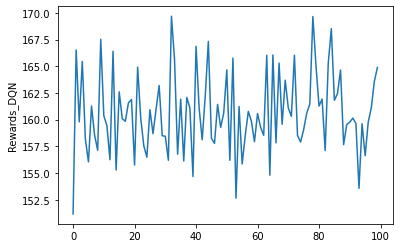

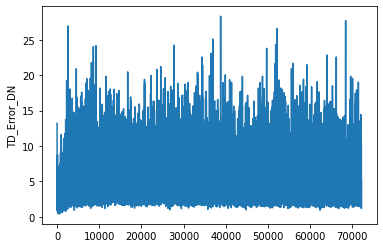

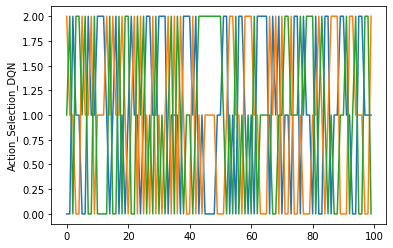

Reward average DQN policy  160.614607976584


In [6]:
print('Complete')
plt.plot(all_rewards)
plt.ylabel('Rewards_DQN')
plt.show()

plt.clf()

plt.plot(all_losses)
plt.ylabel('TD_Error_DN')
plt.show()

plt.clf()

plt.plot(all_actions)
plt.ylabel('Action_Selection_DQN')
plt.show()

print('Reward average DQN policy ', np.mean(all_rewards))

In [7]:
# Running random agent
from recsim.agents import random_agent

num_episodes = 1000
episode_durations = []
all_rewards = []
eps_reward = 0.0
action_space = spaces.MultiDiscrete(n_action * np.ones((1,)))
agent = random_agent.RandomAgent(action_space, random_seed=0)

for i_episode in range(num_episodes):
    # Initialize the environment and state
    obs = env.reset()
    for t in count():
        # Select and perform an action
        action = agent.step(1, observation=obs)
        _, reward, done, _ = env.step(action)
        eps_reward += reward

        if done:
            if i_episode % 10 == 0:
                print('Eps ', i_episode, 'Reward', eps_reward)
            episode_durations.append(t + 1)
            all_rewards.append(eps_reward)
            eps_reward = 0.0
            break


Eps  0 Reward 160.0
Eps  10 Reward 168.00951276493458
Eps  20 Reward 159.66047068042306
Eps  30 Reward 160.0
Eps  40 Reward 169.80912457795603
Eps  50 Reward 188.0
Eps  60 Reward 165.8968544082575
Eps  70 Reward 176.0
Eps  80 Reward 164.0
Eps  90 Reward 172.02172505455763
Eps  100 Reward 148.57963906726786
Eps  110 Reward 168.03984744088558
Eps  120 Reward 172.0
Eps  130 Reward 147.0216989130324
Eps  140 Reward 173.67639691094274
Eps  150 Reward 186.81502520285517
Eps  160 Reward 159.2624484171446
Eps  170 Reward 162.5545216950017
Eps  180 Reward 165.121961098405
Eps  190 Reward 162.54179182939785
Eps  200 Reward 161.85348331278678
Eps  210 Reward 159.8977766891691
Eps  220 Reward 156.54089291528328
Eps  230 Reward 145.16526944677227
Eps  240 Reward 164.0
Eps  250 Reward 160.03120328709716
Eps  260 Reward 175.42151175661945
Eps  270 Reward 156.0
Eps  280 Reward 172.9644522869109
Eps  290 Reward 155.13305405827543
Eps  300 Reward 176.0
Eps  310 Reward 156.74341728916042
Eps  320 Reward 

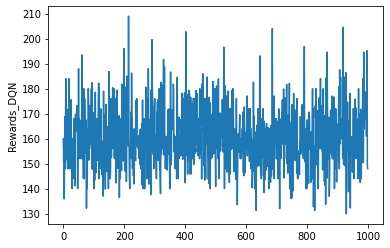

Reward average random policy  160.4901655368859


In [8]:
plt.plot(all_rewards)
plt.ylabel('Rewards_DQN')
plt.show()

print('Reward average random policy ', np.mean(all_rewards))